In [2]:
!pwd

/home/ubuntu/w251finalyolo5


In [3]:
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
#from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

/home/ubuntu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup complete. Using torch 1.11.0+cu102 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=14964MB, multi_processor_count=40)


In [4]:
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="roboflow-yolov5")

upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=roboflow-yolov5


In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="vaBgQYwyCHD76EUqgXOv")
project = rf.workspace("karel-cornelis-q2qqg").project("aicook-lcv4d")
dataset = project.version(4).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to aicook-4 in yolov5pytorch:: 100%|██████████| 6112/6112 [00:02<00:00, 2582.87it/s]


In [6]:
%cat {dataset.location}/data.yaml

names:
- apple
- banana
- beef
- blueberries
- bread
- butter
- carrot
- cheese
- chicken
- chicken_breast
- chocolate
- corn
- eggs
- flour
- goat_cheese
- green_beans
- ground_beef
- ham
- heavy_cream
- lime
- milk
- mushrooms
- onion
- potato
- shrimp
- spinach
- strawberries
- sugar
- sweet_potato
- tomato
nc: 30
train: aicook-4/train/images
val: aicook-4/valid/images


In [7]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [8]:
%cat /home/ubuntu/w251finalyolo5/models/yolov5s.yaml


# parameters
nc: 30  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[

In [9]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [13]:
%%writetemplate /home/ubuntu/w251finalyolo5/models/yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [15]:
!pip install wandb

import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gabrielamaylagunes. Use `wandb login --relogin` to force relogin


True

In [16]:
%%time
!python3 train.py --img 640 --batch 16 --epochs 100 --data {dataset.location}/data.yaml --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name yolov5s_results  --cache

wandb: Currently logged in as: gabrielamaylagunes. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=./models/yolov5s.yaml, data=/home/ubuntu/w251finalyolo5/aicook-4/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/jmiller558/w251finalyolo5 ✅
YOLOv5 🚀 v6.1-306-ga027fbc9 Python-3.8.10 torch-1.11.0+cu102 CUDA:0 (Tesla T4, 14964MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=

In [12]:
!ls runs

CONTRIBUTING.md  __pycache__  export.py		runs		utils
LICENSE		 aicook-4     hubconf.py	setup.cfg	val.py
README.md	 data	      models		train.py	yolov5s.pt
Testrun.ipynb	 detect.py    requirements.txt	tutorial.ipynb


In [13]:
!python export.py --weights 'runs/train/yolov5s_results/weights/best.pt' --include onnx

export: data=data/coco128.yaml, weights=['runs/train/yolov5s_results/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, train=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=12, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v6.1-304-g51fb467 Python-3.8.13 torch-1.13.0a0+340c412 CPU

Fusing layers... 
YOLOv5s summary: 232 layers, 7324731 parameters, 0 gradients, 17.0 GFLOPs

PyTorch: starting from runs/train/yolov5s_results/weights/best.pt with output shape (1, 25200, 35) (56.6 MB)

ONNX: starting export with onnx 1.11.0...
ONNX: export success, saved as runs/train/yolov5s_results/weights/best.onnx (28.4 MB)

Export complete (3.51s)
Results saved to /workspace/w251finalyolo5/runs/train/yolov5s_results/weights
Detect:          python detect.py --weights runs/train/yolov5s_results/weights/best.onnx 
Validate: 

In [17]:
import torch 
import cv2

In [18]:
!pwd

/home/ubuntu/w251finalyolo5


In [37]:
model = torch.hub.load('/home/ubuntu/w251finalyolo5', 'custom', path='/home/ubuntu/w251finalyolo5/runs/train/yolov5s_results/weights/last.pt', source='local')

YOLOv5 🚀 v6.1-306-ga027fbc9 Python-3.8.10 torch-1.11.0+cu102 CUDA:0 (Tesla T4, 14964MiB)

Fusing layers... 
YOLOv5s summary: 232 layers, 7324731 parameters, 0 gradients, 17.0 GFLOPs
Adding AutoShape... 


In [22]:
model.conf = .5

In [25]:
print(model.classes)

None


In [23]:
[i for i in range(30)]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]

In [26]:
model.classes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,26,27,28,
29]

In [27]:
im2 = cv2.imread('aicook-4/test/images/DSC_5941_JPG_jpg.rf.7f34ef03affd2f952f6519e8506d8cdc.jpg')[..., ::-1]

In [28]:
im2.shape

(640, 640, 3)

In [29]:
results = model(im2, size=640)

In [30]:
results

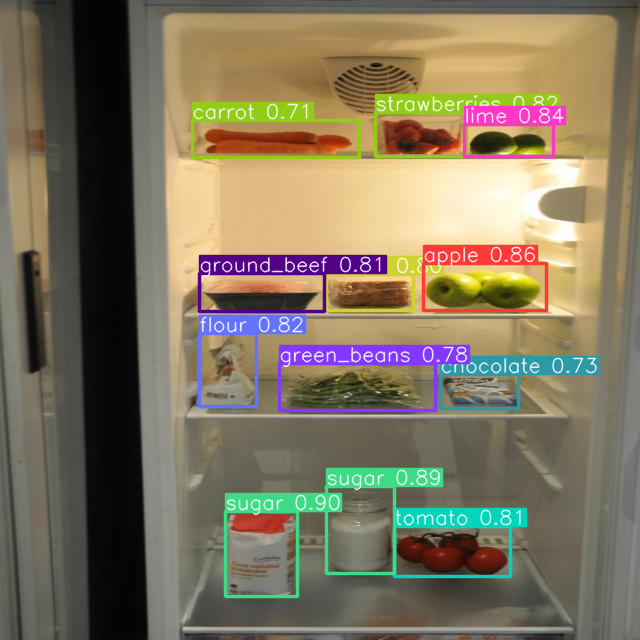

In [31]:
results.show()

In [32]:
results.print()

image 1/1: 640x640 1 apple, 1 bread, 1 carrot, 1 chocolate, 1 flour, 1 green_beans, 1 ground_beef, 1 lime, 1 strawberries, 2 sugars, 1 tomato
Speed: 4.5ms pre-process, 15.8ms inference, 1.9ms NMS per image at shape (1, 3, 640, 640)


In [70]:
cap = cv2.VideoCapture(0)

In [67]:
ret, frame = cap.read()

In [68]:
test = frame[..., ::-1]

In [69]:
test.shape

(480, 640, 3)

In [ ]:
cv2.imwrite('test.jpg',frame)

In [33]:
pwd

'/home/ubuntu/w251finalyolo5'

In [38]:
im2 = cv2.imread('/home/ubuntu/w251finalyolo5/test.jpg')[..., ::-1]

True

In [39]:
results = model(im2, size=640)

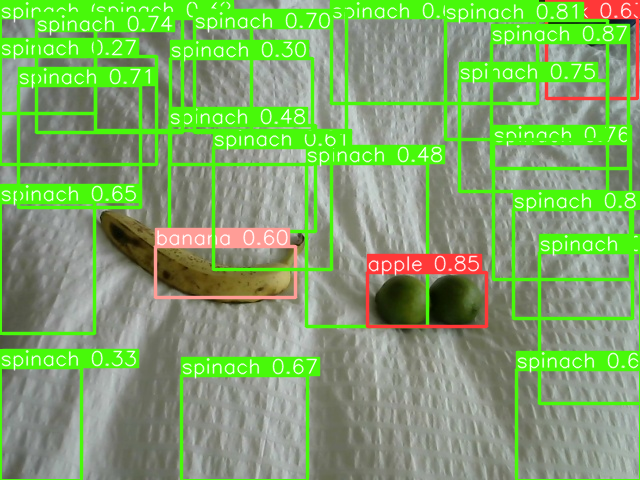

In [40]:
results.show()

In [43]:
!python3 detect.py --source test.jpg --weights 'runs/train/yolov5s_results/weights/last.pt' --img 640 --conf 0.4 --

detect: weights=['runs/train/yolov5s_results/weights/last.pt'], source=test.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
Python 3.7.0 required by YOLOv5, but Python 3.6.9 is currently installed
YOLOv5 \U0001f680 v6.1-305-g222a52c6 Python-3.6.9 torch-1.9.0 CUDA:0 (NVIDIA Tegra X1, 3964MiB)

Fusing layers... 
YOLOv5s summary: 232 layers, 7324731 parameters, 0 gradients, 17.0 GFLOPs
image 1/1 /usr/src/app/test.jpg: 480x640 1 apple, 1 banana, 1 milk, 15 spinachs, Done. (0.153s)
Speed: 141.0ms pre-process, 152.6ms inference, 158.9ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp7


In [43]:
!python3 /home/ubuntu/w251finalyolo5/val.py --weights 'runs/train/yolov5s_results/weights/last.pt' --data {dataset.location}/data.yaml --img 640


val: data=/home/ubuntu/w251finalyolo5/aicook-4/data.yaml, weights=['runs/train/yolov5s_results/weights/last.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-ga027fbc9 Python-3.8.10 torch-1.10.1+cu111 CUDA:0 (Tesla T4, 14964MiB)

Fusing layers... 
YOLOv5s summary: 232 layers, 7324731 parameters, 0 gradients, 17.0 GFLOPs
val: Scanning '/home/ubuntu/w251finalyolo5/aicook-4/valid/labels.cache' images a
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        103       1227      0.938      0.927       0.94      0.588
               apple        103         44      0.907      0.909      0.963      0.721
              banana        103         41      0.971          1      0.995      0.693
         